<table class="sprawko-header" style="width: 90%; border-style: hidden; font-size: 22px; line-height: 1.2em;">
<tr style="border-style: hidden;">
    <td style="width: 50%; border-style: hidden;">Informatyka, studia dzienne, II st.</td>
    <td style="width: 50%; text-align: right; border-style: hidden;">semestr II</td>
</tr>
<tr style="border-style: hidden;">
    <td style="width: 50%; border-style: hidden;">
        <b>Współczesne technologie programowania</b><br> Prowadzący: Kamil Stokfiszewski
    </td>
    <td style="width: 50%; text-align: right; border-style: hidden;">
        2016/2017<br> wtorek, 10:15
    </td>
</tr>
<tr style="border-style: hidden;">
    <td colspan="2">
        <ul style="width: 100%; text-align: center;  list-style: none;">
            <li>Daniel Pęczek 207585</li>
            <li>Michał Sośnicki 207597</li>
        </ul>
    </td>
</tr>
</table>

# Ćwiczenie 2: Obliczenia ogólnego przeznaczenia na procesorach graficznych 

## Wprowadzenie
Zadanie polegało na stworzeniu programu mnożącego macierz przez wektor. Algorytm powinien działać poprawnie dla macierzy kwadratowych o N na N elementach, gdzie N jest całkowitą potęgą dwóch. Należy przy tym zwrócić uwagę na różnice między czasem działania algorytmu w wersji sekwencyjnej i w wersji masowo-równoległej.

## Realizacja

Program wykonujący mnożenie zrealizowano w języku `C++` z wykorzystaniem platformy `CUDA`. Program przyjmuje na wejściu trzy liczby całkowite: rozmiar danych $N$ i zakres danych $min$ i $max$. W pierwszym kroku generowana jest macierz kwadratowa $N \times N$ i wektor długości $N$ i wypełniane są one losowo wartościami z przedziału $[min, max]$. Następnie liczony jest iloczyn macierz - wektor w postaci nowego wektora długości $N$. Dokonywane jest to osobno algorytmem sekwencyjnym i masowo-równoległym. Program mierzy czas działania obu części i wypisuje wyniki. Na koniec obie wartości są porównywane i jeżeli algorytmy dały różne wyniki, to wypisywana jest informacja o tym, a program kończy się błędem.
omiar czasu odbywa się z wykorzystaniem funkcji `clock_gettimez` z parametrem `CLOCK_PROCESS_CPUTIME_ID` w pierwszym przypadku oraz funkcji `cudaEventElapsedTime`, mierzącej czas między dwoma wywołaniami `cudaEventRecord` w drugim.

Analizę czasu wykonywania i wykresy wykonano w środowisku `Jupyter` w języku `Python` z bibliotekami `numpy` oraz `matplotlib`. Skrypty pozyskują wyniki poprzez uruchamianie opisanego wcześniej programu i analizę jego wyjścia. `Jupyter` umożliwia wzbogacenie kodu o dobrze prezentujące się wizualnie bloki `markdown`, więc ta część rozwiązania stanowi zarazem sprawozdanie z zadania.

Testy przeprowadzono na komputerze z kartą graficzną `NVIDIA GeForce GTS 450` (architektura `Fermi`) i procesorem `Intel Core i5-760 2.80 GHz`. Czas jest wyznaczany przez wykonanie sortowania dziesięć razy. Z czasów usuwany jest wynik minimalny i maksymalny, a pozostałe są uśredniane. Od rozmiarów siatek bloków oraz liczby wątków na blok oczekuje się, że w każdym z dziesięciu testów dla tych samych danych będą one takie same. Jest to sprawdzane i jeżeli by tak nie było, generowanie sprawozdania zakończyłoby się błędem. 

In [1]:
import functools as fn
import math
import re
import subprocess as sp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display

In [2]:
def run_get_stdout(name, *args):
    subprocess_args = [name] + list(map(str, args))
    output = sp.run(subprocess_args, stdout=sp.PIPE).stdout
    return output.decode('utf-8')

OUTPUT_REGEX = re.compile(r"CPU time: (\d+\.\d+)s\n"
                          r"Block: (\d+) (\d+) (\d+)\n"
                          r"Thread: (\d+) (\d+) (\d+)\n"
                          r"GPU time: (\d+\.\d+)ms\n")

def parse_multiplication(output):
    match = OUTPUT_REGEX.fullmatch(output)
    cpu_time_ms = float(match.group(1)) * 1000
    block_counts = map(int, match.group(2, 3, 4))
    thread_counts = map(int, match.group(5, 6, 7))
    gpu_time_ms = float(match.group(8))
    return (cpu_time_ms, tuple(block_counts), tuple(thread_counts), gpu_time_ms)

def all_rows_equal(matrix):
    np_matrix = np.array(matrix)
    if np_matrix.size == 0:
        return True
    return np.all(np_matrix == np_matrix[0,:])

def aggregate_multiplications(results):
    cpu_times, block_countss, thread_countss, gpu_times = zip(*results)
    mean_cpu_time = np.sort(cpu_times)[1:-1].mean()
    mean_gpu_time = np.sort(gpu_times)[1:-1].mean()
                  
    if not all_rows_equal(block_countss):
        raise ValueError("Block counts not equal")
    block_counts = block_countss[0]
    
    if not all_rows_equal(thread_countss):
        raise ValueError("Thread counts not equal")
    thread_counts = thread_countss[0]
                  
    return (mean_cpu_time, mean_gpu_time, block_counts, thread_counts)

def run_multiplication(repeats, size, a, b):
    outputs = [run_get_stdout('../Zadanie 2/main.out', size, a, b) for _ in range(repeats)]
    results = [parse_multiplication(output) for output in outputs]
    return aggregate_multiplications(results)

## Porównanie czasu działania na CPU i GPU

Program uruchomiono dziesięć dla rozmiarów danych będących kolejnymi potęgami dwójki od $2$ do $512$.
Dane generowane są z przedziału $[10^{-10}, 10^{10}]$. Wyniki zaprezentowano poniżej.

Jak widać wykonywanie obliczeń algorytmem sekwencyjnym jest szybsze aż do momentu przejścia z rozmiaru $64$ do $128$,
gdzie algorytm masowo-równoległy zaczyna mieć przewagę. Dla większych macierzy wykonywanie obliczeń na GPU jest około
$50%$ szybsze.

Wynika z tego iż z wykonywaniem obliczeń na GPU wiąże się pewien stały koszt inicjalizacji, który sprawia, że lepiej
jest dla mniejszych danych wykonać obliczenia na CPU. Oba algorytmy, sądząc po wykresach, mają kwadratową złożoność obliczeniową względem parametru rozmiaru, czyli liniową względem liczby elementów macierzy. Ma to sens, gdyż liczba mnożeń i dodawań do wykonania jest równa liczbie elementów w macierzy i jest to prawdą dla obu algorytmów. GPU co prawda daje możliwości zrównoleglania obliczeń, lecz na etapie dodawania wymagana jest synchronizacja wątków, którą w programie uzyskano przez użycie funkcji `atomicAdd`. Z drugiej strony jest prawdopodobnie możliwy uzyskanie większego przyspieszenia algorytmu masowo-równoległego po wgłębieniu się w mechanizmy CUDA i na przykład zsumowaniu rzędów z wykorzystaniem pamięci współdzielonej zamiast globalnej.   

In [3]:
def plot_to_data(data_sizes, running_times, ylabel, show=True):
    ax = plt.subplot(1, 1, 1)
    plt.plot(np.arange(data_sizes.size), running_times, 'o')
    plt.ylabel(ylabel)
    plt.xlabel('Rozmiar wektora i macierzy kwadratowej')
    ax.set_xticklabels(data_sizes)
    if show:
        plt.show()
    
def plot_times(data_sizes, results):
    cpu_times, gpu_times, _, _ = zip(*results)
    plot_to_data(data_sizes, cpu_times, 'Running times (CPU) [ms]')
    plot_to_data(data_sizes, gpu_times, 'Running times (GPU) [ms]')
    
def display_ratios(data_sizes, results):
    cpu_times, gpu_times, _, _ = zip(*results)
    time_ratios = np.array(cpu_times) / np.array(gpu_times)
    all_data = np.vstack([data_sizes, cpu_times, gpu_times, time_ratios]).T
    col_names = ['Data size', 'CPU time [ms]', 'GPU time [ms]', 'CPU / GPU time ratio']
    df = pd.DataFrame(all_data, columns=col_names)
    plot_to_data(data_sizes, time_ratios, 'CPU / GPU time ratio')
    display(df)
    
data_sizes = np.exp2(np.arange(1, 10)).astype(np.int32)

In [4]:
results_large = [run_multiplication(10, data_size, 1e-10, 1e10) for data_size in data_sizes]

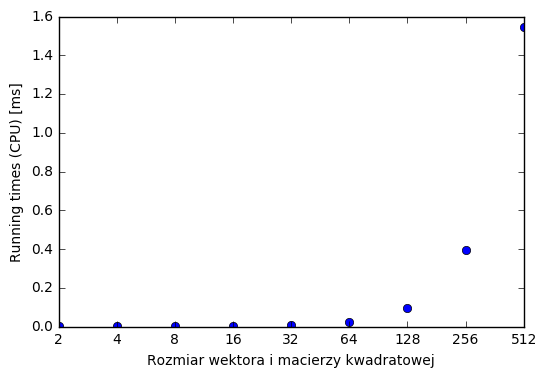

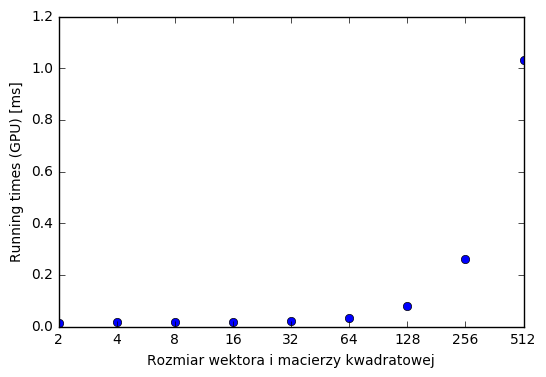

In [5]:
plot_times(data_sizes, results_large)

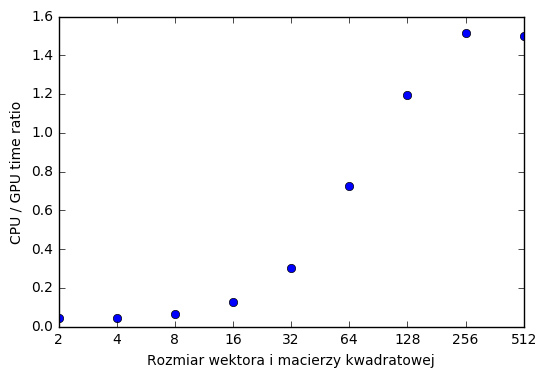

,Data size,CPU time [ms],GPU time [ms],CPU / GPU time ratio
0,2.0,0.000641,0.014896,0.043032
1,4.0,0.000714,0.016216,0.044007
2,8.0,0.001024,0.016360,0.062569
3,16.0,0.002156,0.017036,0.126534
4,32.0,0.006684,0.022016,0.303620
5,64.0,0.025027,0.034396,0.727614
6,128.0,0.097223,0.081252,1.196555
7,256.0,0.395028,0.261196,1.512380
8,512.0,1.543604,1.030304,1.498202


In [6]:
display_ratios(data_sizes, results_large)

## Wybór rozmiaru bloku oraz siatki bloków

W programie konieczne było zadecydowanie o liczbie wątków w każdym bloku oraz liczbie bloków w całej siatce bloków. 
Zaprojektowany algorytm wykorzystuje jeden wątek na każdy element macierzy, więc iloczyn liczby bloków i liczby wątków na blok musiał być większy bądź równy rozmiarowi macierzy. Procesor graficzny wykorzystany do testów w architekturze `Fermiego` pozwala na uruchomienie do $1024$ wątków w bloku, przy czym grupowane są one w osnowy o rozmiarze $32$, więc dobrze było, by wybrana liczba wątków na blok była wielokrotnością $32$. 

Wygląda na to, iż w praktyce wartości tych parametrów dobiera się testując algorytm w praktyce. W naszym programie wykorzystaliśmy jednak funkcję dostarczaną przez platformę `Cuda` o nazwie `cudaOccupancyMaxPotentialBlockSize`, która szacuje te wartości. Wykorzystaliśmy je bez dalszych testów. Jak widać program używa jednego bloku aż do użycia $768$ wątków na blok, po czym zwiększa już tylko liczbę bloków.

In [7]:
def display_counts(data_sizes, results):
    _, _, block_counts, thread_counts = zip(*results)
    np_block_counts = np.array(block_counts)[:, :2]
    np_thread_counts = np.array(thread_counts)[:, :2]
    all_data = np.hstack((np_block_counts, np_thread_counts))
    data_frame = pd.DataFrame(all_data, index=data_sizes, columns=[
        'Block x', 'Block y', 'Thread x', 'Thread y'
    ])
    display(data_frame)

In [8]:
display_counts(data_sizes, results_large)

,Block x,Block y,Thread x,Thread y
2,1,1,2,2
4,1,1,4,4
8,1,1,8,8
16,1,1,16,16
32,1,2,32,24
64,2,3,32,24
128,4,6,32,24
256,8,11,32,24
512,16,22,32,24


## Czas działania przy małej liczbie możliwych wartości

Postanowiliśmy jeszcze przetestować czy zakres danych, na których przeprowadzane są operacje ma znaczenie dla czasu obliczeń. Miało to ogromne znaczenie przy poprzednim zadaniu, jednak algorytmy w tym zadaniu okazały się zupełnie niezależne. Poniżej zaprezentowano wyniki dla przedziału $[0, 10]$ i są one bardzo podobne to poprzednich, z zakresu $[10^{-10}, 10^{10}]$. 

In [9]:
results_small = [run_multiplication(10, data_size, 0, 10) for data_size in data_sizes]

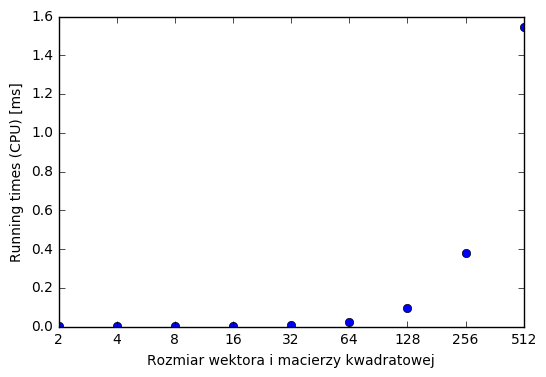

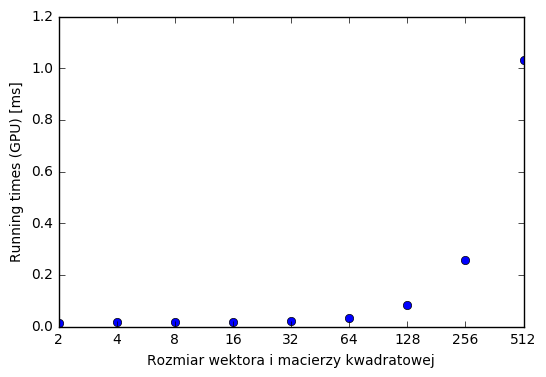

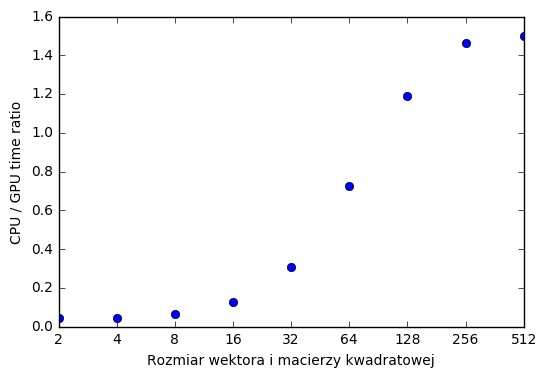

,Data size,CPU time [ms],GPU time [ms],CPU / GPU time ratio
0,2.0,0.000624,0.014952,0.041708
1,4.0,0.000711,0.016328,0.043560
2,8.0,0.001046,0.016212,0.064543
3,16.0,0.002128,0.016844,0.126314
4,32.0,0.006661,0.021808,0.305421
5,64.0,0.025020,0.034552,0.724122
6,128.0,0.097267,0.081728,1.190131
7,256.0,0.378569,0.258356,1.465301
8,512.0,1.544968,1.032125,1.496881


In [10]:
plot_times(data_sizes, results_small)
display_ratios(data_sizes, results_small)